In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings 
warnings.filterwarnings("ignore")

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper.
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# Create engine to hawaii.sqlite.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model.
Base = automap_base()

# Reflect the tables.
Base.prepare(autoload_with=engine, reflect=True)

In [6]:
# View all of the classes that automap found.
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table.
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB.
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get columns and types for measurement.
inspect_meas = inspect(engine)
columns_meas = inspect_meas.get_columns('measurement')
for c in columns_meas:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
date_query = session.query(measurement.date).order_by(measurement.date.desc()).first()
date_query

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=364)
query_year_ago

datetime.date(2016, 8, 24)

In [12]:
# Perform a query to retrieve the date and precipitation scores.
precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-24').filter(measurement.date <= '2017-08-23').all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column.
precip_df = pd.DataFrame(precip).set_index('date')

# Clean up dataframe by renaming prcp column.
precip_df = precip_df.rename(columns={'prcp':'precipitation'})
precip_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [14]:
# Sort the dataframe by date.
precip_df = precip_df.sort_values(by='date')
precip_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


In [15]:
# Drop NaN values from the dataframe.
precip_df = precip_df.dropna()
precip_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


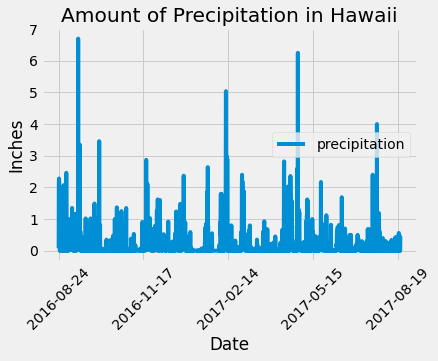

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data.
precip_df.plot(rot=45)
plt.title("Amount of Precipitation in Hawaii")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig("Hawaii Precipitation (8-23-2016 to 8-23-2017).png")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data.
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Get columns and types for station.
inspect_stat = inspect(engine)
columns_stat = inspect_stat.get_columns('station')
for c in columns_stat:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to calculate the total number stations in the dataset.
station_count = session.query(station).count()
print(f'There are {station_count} stations in this dataset.')

There are 9 stations in this dataset.


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?).
# List the stations and the counts in descending order (source: https://github.com/goldenb85/sqlalchemy-challenge/blob/master/climate_starter.ipynb).
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Identify the busiest station based upon the number of reports made.
print(f'The busiest station is USC00519281, located at WAIHEE.')

The busiest station is USC00519281, located at WAIHEE.


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
busy_station = 'USC00519281'
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == busy_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Using the most active station id.
# Query the last 12 months of temperature observation data for this station.
busy_station_12_months = session.query(measurement.date, measurement.tobs).filter(measurement.date >= '2016-08-24').filter(measurement.date <= '2017-08-23').filter(measurement.station == busy_station).all()

busy_station_df = pd.DataFrame(busy_station_12_months)
busy_station_df.dropna()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


<AxesSubplot:ylabel='Frequency'>

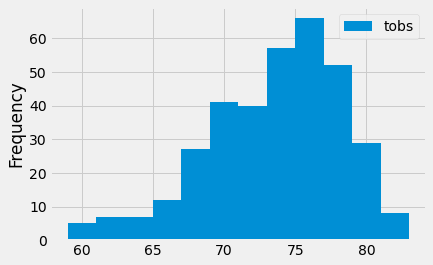

In [24]:
# Plot the results as a histogram.
busy_station_df.plot.hist(bins=12)

# Close session

In [25]:
# Close Session.
session.close()